In [1]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch/

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже)
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [3]:
batch_size = 64 # по какому количеству объектов выборки будем оценивать градиент 
anomaly_digit = 0 # какую цифру примем за аномалию

In [4]:
# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = datasets.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = datasets.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

class AnomalyWrapper(torch.utils.data.Dataset):
    def __init__(self, mnist_set, anomaly_digit, num_anomalies=None):
        real = mnist_set.targets != anomaly_digit
        if not num_anomalies:
            num_anomalies = (~real).sum()
        self.data = torch.cat([mnist_set.data[real], mnist_set.data[~real][:num_anomalies]]).unsqueeze(1)
        self.target = torch.cat([torch.ones(real.sum()), torch.zeros(num_anomalies)])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index].float(), self.target[index]
    
        


train_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)

test_loader = torch.utils.data.DataLoader(AnomalyWrapper(mnist_test, anomaly_digit),
                                           batch_size=batch_size,
                                           shuffle=True,
                                           drop_last=True)


get_dset = lambda x: torch.utils.data.DataLoader(AnomalyWrapper(mnist_train, anomaly_digit, x),
                                                batch_size=batch_size,
                                                shuffle=True,
                                                drop_last=True)



Label: 5


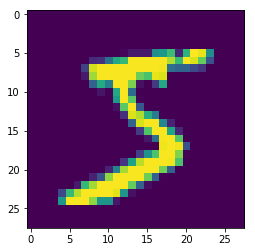

In [5]:
img, label = mnist_train[0] # первый элемент обучающей выборки
print(f'Label: {label}')
plt.imshow(img[0,:,:])
plt.show()

# Baseline
В качестве бейзлайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [6]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(4*4*32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
# model = AlexNet(num_classes=1).cuda()

# criterion = nn.BCEWithLogitsLoss() 
# opt = torch.optim.Adam(model.parameters())


In [7]:
from sklearn.metrics import confusion_matrix

conf_metric = lambda labels, preds: confusion_matrix(labels, np.round(preds))

In [8]:
from tqdm import tqdm_notebook

def train(loader):
    model.train()
    for j, (image,label) in tqdm_notebook(enumerate(loader), desc='train', leave=False):
        image, label = image.cuda(), label.cuda().float()
        opt.zero_grad()
        output = model(image).squeeze()
        loss = criterion(output, label)
        loss.backward()
        opt.step()

def evaluate(metric):
    model.eval()
    preds, labels = [], []
    for j, (image,label) in tqdm_notebook(enumerate(test_loader), desc='test', leave=False):
        image, label = image.cuda(), label.float()
        output = torch.sigmoid(model(image)).squeeze()
        preds.extend(output.detach().cpu().tolist())
        labels.extend(label.detach().tolist())
    return metric(labels, preds)

def train_eval(loader, num_epoch=10, metric=roc_auc_score):
    for epoch in range(num_epoch):
        train(loader)
    return evaluate(metric)



In [9]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=conf_metric)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
[[ 294  682]
 [   0 9008]]


Anomalies: 50, metric: 
[[ 884   95]
 [   1 9004]]


Anomalies: 100, metric: 
[[ 786  192]
 [   0 9006]]


Anomalies: 500, metric: 
[[ 961   18]
 [   4 9001]]


Anomalies: 1000, metric: 
[[ 956   23]
 [   1 9004]]


Anomalies: None, metric: 
[[ 976    3]
 [  10 8995]]



In [10]:
for num_anomalies in tqdm_notebook([10, 50, 100, 500, 1000, None]):
    dset = get_dset(num_anomalies)
    
    model = AlexNet(num_classes=1).cuda()

    criterion = nn.BCEWithLogitsLoss() 
    opt = torch.optim.Adam(model.parameters())

    metric = train_eval(dset, metric=roc_auc_score)
    print(f"Anomalies: {num_anomalies}, metric: \n{metric}")

Anomalies: 10, metric: 
0.9860693667517592


Anomalies: 50, metric: 
0.9941510122485244


Anomalies: 100, metric: 
0.9907231806834526


Anomalies: 500, metric: 
0.9998347697043094


Anomalies: 1000, metric: 
0.9998542212485473


Anomalies: None, metric: 
0.9999819643949934

